In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

from pathlib import Path
import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
sys.path.append(os.path.join(ipynb_dir, '..'))  # Needed for import below

from sc2sensor.dataset import SensorMNIST
from sc2sensor.dataset import LABELS_DICT, DEFAULT_10
from sc2sensor.utils.image_utils import imshow


root = '/local/scratch/a/shared/starcraft_shared'
subdir = 'starcraft-sensor-dataset'
model_root_dir = Path('models')

IMAGE_SIZE = [1, 28,28]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class CorruptedSensorNetwork():
    
    def __init__(self, sensor_radius, random_state=42):
        """Simulates a single sensor fault with given radius"""
        self.sensor_radius = sensor_radius
        self.rng = np.random.RandomState(42)
        
    @staticmethod    
    def create_circular_mask(h, w, center=None, radius=None):

        if center is None: # use the middle of the image
            center = (int(w/2), int(h/2))
        if radius is None: # use the smallest distance between the center and image walls
            radius = min(center[0], center[1], w-center[0], h-center[1])

        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

        mask = dist_from_center <= radius
        return torch.tensor(mask)
    
    def simulate_sensor_fault(self, image):
        image_size = image.shape[-2:]
        sensor_location = [torch.randint(4, image_size[side_idx]-4, size=(1,)).item() for side_idx in range(2)]
        # creating a mask where Ture if that coordinate is in the sensor's range
        sensor_visual_range = self.create_circular_mask(image_size[0], image_size[1],
                                                        sensor_location, self.sensor_radius)
        
        return image.masked_fill(sensor_visual_range, -1)  # set anywhere in that sensors range to -1
            
    def __call__(self, image):
        return self.simulate_sensor_fault(image)

In [3]:
class CorruptedSensorDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, faulty_sensor_radius, random_state=42):
        self.dataset = dataset
        self.corrupt_sensor = CorruptedSensorNetwork(faulty_sensor_radius, random_state)
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # getting target (uncorrupted image)
        corrupted_image = self.corrupt_sensor(image)  # making input (corrupted image)
        return corrupted_image, image

In [4]:
faulty_sensor_radius = 5

transform = transforms.ToTensor()

batch_size = 256

mnist_trainset = SensorMNIST(root=root, subdir=subdir, train=True, transform=transform)
trainset = CorruptedSensorDataset(mnist_trainset, faulty_sensor_radius)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

mnist_testset = SensorMNIST(root=root, subdir=subdir, train=False, transform=transform)
testset = CorruptedSensorDataset(mnist_testset, faulty_sensor_radius)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16)

dataloaders = {'train': trainloader, 'val':testloader}

Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorMNIST_train.npz
Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorMNIST_test.npz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


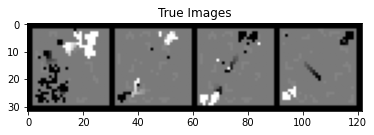

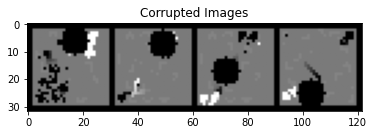

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(trainloader)
corr_images, true_images = dataiter.next()

# show corr(upted) images
imshow(torchvision.utils.make_grid(true_images[:min(4, batch_size)]), title='True Images')
# show true image
imshow(torchvision.utils.make_grid(corr_images[:min(4, batch_size)]), title='Corrupted Images')
plt.show()

In [6]:
# from torchvision.models.resnet import resnet101

# class ViewToImage(torch.nn.Module):
#     def __init__(self, image_size):
#         super().__init__()
#         self.image_size = image_size
        
#     def __call__(self, x):
#         return x.view(-1, *self.image_size)

# model = resnet101()
# model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.fc = torch.nn.Linear(in_features=2048, out_features=np.prod(IMAGE_SIZE))  # changing head to match image output size
# model = torch.nn.Sequential(model, ViewToImage(IMAGE_SIZE)).to(device)



# # setting up optimizer
# optimizer = torch.optim.Adam(model.parameters(), 5e-3)
# criterion = torch.nn.MSELoss()

In [7]:
import torch.nn as nn
import torch.nn.functional as F
# setting up the model
class VAEImputator(nn.Module):
    
    def __init__(self, latent_dim=64, hidden_dims=[32, 64, 128, 128, 512]):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        multipler = 1
        
        # Build Encoder
        modules = []
        in_channels = 1  # initialize to 1 channels for input
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()))
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*multipler, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*multipler, latent_dim)
        
        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*multipler)
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=5,
                                       stride = 2,
                                       padding=1,
                                       output_padding=0),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()))
        self.decoder = nn.Sequential(*modules)
        
        self.final_layer = nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[-1],
                                       hidden_dims[-1],
                                       kernel_size=2,
                                       stride=1,
                                       padding=3,
                                       dilation=2,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[-1]),
                    nn.LeakyReLU(),
                    nn.Conv2d(hidden_dims[-1], out_channels=1,
                              kernel_size= 3, padding= 1),
                    nn.Sigmoid())
        
    def encode(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(x)
        #  print(f'Encoded {result.shape}')
        result = torch.flatten(result, start_dim=1)
        #  print(f'Flattened {result.shape}')

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        #  print(f'Mued {mu.shape}')
        log_var = self.fc_var(result)
        #  print(f'log_var {log_var.shape}')
        
        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        #  print(f'decoded_input {result.shape}')
        result = result.view(-1, self.hidden_dims[0], 1, 1)
        #  print(f'viewed {result.shape}')
        result = self.decoder(result)
        #  print(f'decoder {result.shape}')
        result = self.final_layer(result)
        #  print(f'final layer {result.shape}')
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        #  print(f'std {std.shape}')
        eps = torch.randn_like(std)
        #  print(f'eps {eps.shape}')
        return eps * std + mu

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        #  print(f'z {z.shape}')
        recon = self.decode(z)
        return  [recon, x, mu, log_var]

    def sample(self, n_samples, device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(n_samples,
                        self.latent_dim)

        z = z.to(device)

        samples = self.decode(z)
        return samples

    def predict(self, x):
        """
        Given an input image x, returns the predicted image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        return self.forward(x)[0]

In [8]:
model = VAEImputator().to(device)
# setting up optimizer
optimizer = torch.optim.Adam(model.parameters(),  5e-3)
# setting up loss function
def criterion(model_outputs, target):
        """
        Computes the VAE loss function, but with reconstruction error based off the **target**.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        """
        # Note, here target_predicted \neq \hat{x}, instead it is \hat{frame_stack[x_time + time_step]}
        target_predicted, _, mu, log_var = model_outputs
        
        kld_weight = 0.00025 # Account for the minibatch samples from the dataset
        target_predicted_loss =F.mse_loss(target_predicted, target)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = 10 * target_predicted_loss + kld_weight * kld_loss
        return loss

In [9]:
import time
import copy
from tqdm.notebook import tqdm
def train_model(model, dataloaders, criterion,
                optimizer, model_dir,
                device=None, n_epochs=25, verbose=True, log=True):
    """A general(ish) training function which does training + a per-epoch validation for a given model,
    dataloader dict (a dict containing training and val dataloaders), criterion (loss function), and
        an already initialized optimizer (e.g. Adam which has model.learnable_parameters() already registered).
    """   
    if not model_dir.exists():
        model_dir.mkdir(parents=True)
        
    if log:
        with open(model_dir/'training_log.txt', 'w') as f:
            # overwritting the current log file
            from datetime import date
            f.write(f'Training log for : {str(date.today())}\n')
   
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
       
    start_time = time.time()

    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 9e6

    for epoch in tqdm(range(1,n_epochs+1)):
        print(f'Epoch {epoch} / {n_epochs}')
        print('-' * 10)

        # we're combining train+val into one call
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
                # wrapping the training epoch with tqdm to get a progress bar
                data_iterator = dataloaders['train']
                print_on_batch = int(np.ceil(len(data_iterator) / 10))
               
            else:
                model.eval()  # set model to evaluate mode
                # validation is quite fast, so no need for tqdm wrapper
                data_iterator = dataloaders['val']

            running_loss = 0.0

            for batch_idx, (inputs, targets) in enumerate(data_iterator):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # enable gradient tracking only if we are training
                with torch.set_grad_enabled(phase == 'train'):
                    # get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
               
                # if verbose: printing training batch progress
                if phase == 'train' and (batch_idx+1) % print_on_batch == 0 and verbose==True:
                    n_samples_so_far = (batch_idx+1) * dataloaders['train'].batch_size
                    print(f'\tBatch {batch_idx}/{len(data_iterator)}: ',
                          f'running loss={running_loss / n_samples_so_far:.3f}')
                   
            # end epoch iteration
            epoch_loss = running_loss / len(dataloaders[phase].sampler)
           
            print(f'Total {phase}\tLoss: {epoch_loss:.4f}')
           
            if log:
                with open(model_dir/'training_log.txt', 'a') as f:
                    f.write(f'Epoch {epoch}, {phase}\tLoss: {epoch_loss:.4f}')
                    if phase == 'val' and epoch_loss > best_val_loss:
                        f.write(f'--- New best validation! Model saved to {str(model_dir/"model.pt")}. ---\n')

            if phase == 'val' and epoch_loss < best_val_loss:
                # if best validation phase so far, deep copy the model
                best_val_loss = epoch_loss
                if isinstance(model, nn.DataParallel):
                    # if the model is parallized, save only the module (i.e. just the unparallized model)
                    torch.save(model.module.state_dict(), model_dir / 'model.pt')
                else:
                    torch.save(model.state_dict(), model_dir / 'model.pt')
                print(f'New best validation! Model saved.')
                
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            else:
                train_loss_history.append(epoch_loss)

        print()
       
   
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best model saved to {str(model_dir / "model.pt")}')
    print(f'\tBest model val loss: {best_val_loss:.4f}')
   
    if log:
        with open(model_dir/'training_log.txt', 'a') as f:
            f.write('\n\n\n Finished training!')
            f.write(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')
            f.write(f'Best model saved to {str(model_dir / "model.pt")}\n')
            f.write(f'\tBest model val loss: {best_val_loss:.4f}\n')
       
    # load best model weights
    if isinstance(model, nn.DataParallel):
        model.module.load_state_dict(torch.load(model_dir / 'model.pt'))
    else:
        model.load_state_dict(torch.load(model_dir / 'model.pt'))
    return model, train_loss_history, val_loss_history

In [10]:
# training vae on frame prediction
model_dir = model_root_dir / 'sensor-data-imputation'
n_epochs = 100

model, train_hist, val_hist = train_model(model, dataloaders, criterion,
                                          optimizer, model_dir, device, n_epochs=n_epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 / 100
----------
	Batch 23/235:  running loss=0.233
	Batch 47/235:  running loss=0.224
	Batch 71/235:  running loss=0.219
	Batch 95/235:  running loss=0.217
	Batch 119/235:  running loss=0.215
	Batch 143/235:  running loss=0.213
	Batch 167/235:  running loss=0.210
	Batch 191/235:  running loss=0.208
	Batch 215/235:  running loss=0.207
Total train	Loss: 0.2056
Total val	Loss: 0.1909
New best validation! Model saved.

Epoch 2 / 100
----------
	Batch 23/235:  running loss=0.191
	Batch 47/235:  running loss=0.188
	Batch 71/235:  running loss=0.186
	Batch 95/235:  running loss=0.183
	Batch 119/235:  running loss=0.177
	Batch 143/235:  running loss=0.172
	Batch 167/235:  running loss=0.167
	Batch 191/235:  running loss=0.162
	Batch 215/235:  running loss=0.158
Total train	Loss: 0.1555
Total val	Loss: 0.1237
New best validation! Model saved.

Epoch 3 / 100
----------
	Batch 23/235:  running loss=0.123
	Batch 47/235:  running loss=0.122
	Batch 71/235:  running loss=0.121
	Batch 95/235:

	Batch 95/235:  running loss=0.094
	Batch 119/235:  running loss=0.093
	Batch 143/235:  running loss=0.093
	Batch 167/235:  running loss=0.093
	Batch 191/235:  running loss=0.093
	Batch 215/235:  running loss=0.093
Total train	Loss: 0.0934
Total val	Loss: 0.0952
New best validation! Model saved.

Epoch 21 / 100
----------
	Batch 23/235:  running loss=0.091
	Batch 47/235:  running loss=0.092
	Batch 71/235:  running loss=0.093
	Batch 95/235:  running loss=0.093
	Batch 119/235:  running loss=0.093
	Batch 143/235:  running loss=0.093
	Batch 167/235:  running loss=0.093
	Batch 191/235:  running loss=0.093
	Batch 215/235:  running loss=0.093
Total train	Loss: 0.0931
Total val	Loss: 0.0952

Epoch 22 / 100
----------
	Batch 23/235:  running loss=0.093
	Batch 47/235:  running loss=0.093
	Batch 71/235:  running loss=0.093
	Batch 95/235:  running loss=0.093
	Batch 119/235:  running loss=0.093
	Batch 143/235:  running loss=0.093
	Batch 167/235:  running loss=0.093
	Batch 191/235:  running loss=0.0

	Batch 215/235:  running loss=0.089
Total train	Loss: 0.0895
Total val	Loss: 0.0949

Epoch 41 / 100
----------
	Batch 23/235:  running loss=0.089
	Batch 47/235:  running loss=0.089
	Batch 71/235:  running loss=0.089
	Batch 95/235:  running loss=0.089
	Batch 119/235:  running loss=0.089
	Batch 143/235:  running loss=0.089
	Batch 167/235:  running loss=0.089
	Batch 191/235:  running loss=0.089
	Batch 215/235:  running loss=0.089
Total train	Loss: 0.0894
Total val	Loss: 0.0944

Epoch 42 / 100
----------
	Batch 23/235:  running loss=0.090
	Batch 47/235:  running loss=0.089
	Batch 71/235:  running loss=0.089
	Batch 95/235:  running loss=0.089
	Batch 119/235:  running loss=0.089
	Batch 143/235:  running loss=0.089
	Batch 167/235:  running loss=0.089
	Batch 191/235:  running loss=0.089
	Batch 215/235:  running loss=0.089
Total train	Loss: 0.0892
Total val	Loss: 0.0940

Epoch 43 / 100
----------
	Batch 23/235:  running loss=0.088
	Batch 47/235:  running loss=0.089
	Batch 71/235:  running loss=

	Batch 143/235:  running loss=0.087
	Batch 167/235:  running loss=0.087
	Batch 191/235:  running loss=0.087
	Batch 215/235:  running loss=0.087
Total train	Loss: 0.0871
Total val	Loss: 0.0942

Epoch 62 / 100
----------
	Batch 23/235:  running loss=0.087
	Batch 47/235:  running loss=0.087
	Batch 71/235:  running loss=0.087
	Batch 95/235:  running loss=0.087
	Batch 119/235:  running loss=0.087
	Batch 143/235:  running loss=0.087
	Batch 167/235:  running loss=0.087
	Batch 191/235:  running loss=0.087
	Batch 215/235:  running loss=0.087
Total train	Loss: 0.0870
Total val	Loss: 0.0942

Epoch 63 / 100
----------
	Batch 23/235:  running loss=0.086
	Batch 47/235:  running loss=0.086
	Batch 71/235:  running loss=0.086
	Batch 95/235:  running loss=0.087
	Batch 119/235:  running loss=0.086
	Batch 143/235:  running loss=0.087
	Batch 167/235:  running loss=0.087
	Batch 191/235:  running loss=0.087
	Batch 215/235:  running loss=0.087
Total train	Loss: 0.0869
Total val	Loss: 0.0941

Epoch 64 / 100
--

	Batch 95/235:  running loss=0.085
	Batch 119/235:  running loss=0.085
	Batch 143/235:  running loss=0.085
	Batch 167/235:  running loss=0.085
	Batch 191/235:  running loss=0.085
	Batch 215/235:  running loss=0.085
Total train	Loss: 0.0853
Total val	Loss: 0.0946

Epoch 83 / 100
----------
	Batch 23/235:  running loss=0.085
	Batch 47/235:  running loss=0.085
	Batch 71/235:  running loss=0.085
	Batch 95/235:  running loss=0.085
	Batch 119/235:  running loss=0.085
	Batch 143/235:  running loss=0.085
	Batch 167/235:  running loss=0.085
	Batch 191/235:  running loss=0.085
	Batch 215/235:  running loss=0.085
Total train	Loss: 0.0852
Total val	Loss: 0.0948

Epoch 84 / 100
----------
	Batch 23/235:  running loss=0.084
	Batch 47/235:  running loss=0.085
	Batch 71/235:  running loss=0.085
	Batch 95/235:  running loss=0.085
	Batch 119/235:  running loss=0.085
	Batch 143/235:  running loss=0.085
	Batch 167/235:  running loss=0.085
	Batch 191/235:  running loss=0.085
	Batch 215/235:  running loss=0

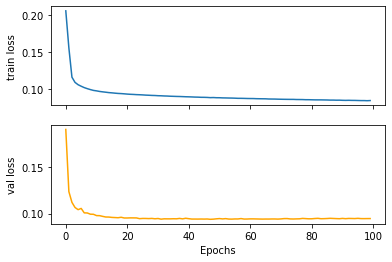

In [11]:
# Displaying training results
fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(train_hist, label='train')
axes[0].set_ylabel('train loss')
axes[1].plot(val_hist, label='val', color='orange')
axes[1].set_ylabel('val loss')
axes[1].set_xlabel('Epochs')
plt.savefig(model_dir / 'train_val_plots.png')
plt.show()

In [16]:
def plot_frames(frames, show=True, axes=None, line_idx=None):
    """frames must be len=3 (input, true, pred)"""
    
    frames[0] = torch.cat
    
    
    if axes is None:
        fig, axes = plt.subplots(1, 3)
    else:
        assert axes.ndim == 1
    if line_idx == 0:    
        imshow(frames[1], ax=axes[1], title='True windows')
        imshow(frames[2], ax=axes[2], title='Pred windows')
        imshow(frames[0], ax=axes[0], title='Input windows')
    else:
        imshow(frames[1], ax=axes[1])
        imshow(frames[2], ax=axes[2])
        imshow(frames[0], ax=axes[0])
    for ax in axes:
        ax.axis('off')
    
    if show:
        plt.tight_layout()
        plt.show()
    return axes

def test_and_plot_model(model, dataloader, n_test_samples=10, axes=None, rng=None):
    if rng is None:
        rng = np.random.RandomState(42)
    for (inputs, targets) in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            # get model predictions and calculate loss
            predictions = model.predict(inputs)
        break
        
    for sample_idx in range(n_test_samples):
        idx = rng.choice(predictions.shape[0])
        if axes is None:
            plot_frames([inputs[idx].cpu(), targets[idx].cpu(), predictions[idx].cpu()])
        else:
            plot_frames([inputs[idx].cpu(), targets[idx].cpu(), predictions[idx].cpu()],
                        axes=axes[sample_idx], show=False, line_idx=sample_idx)
    return inputs, predictions, targets

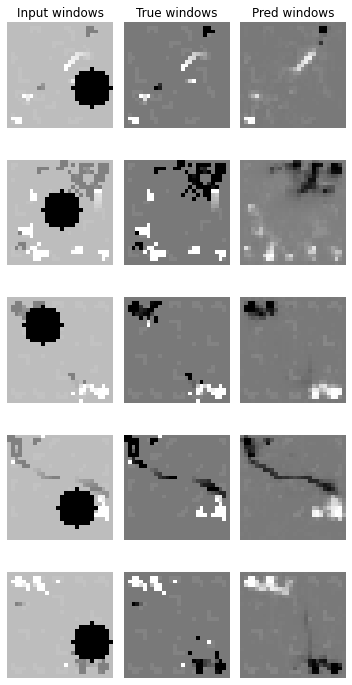

In [75]:
fig, axes = plt.subplots(5, 3, figsize=(5,10))

rng = np.random.RandomState(np.random.randint(1000))
_ = test_and_plot_model(model, dataloaders['val'], n_test_samples=5, rng=rng, axes=axes)
plt.tight_layout()
plt.savefig('missing-sensor-data-imputation.pdf')
plt.show()